In [12]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def find_maxes(scan):
    """
    This function takes in a 3D array of intensity values for pixels in an AFM micrograph and returns the maximum
    value for each of the scan types as a vector
    
    input: numpy ndarray of 3 dimensions containing AFM scan data
    output: numpy array of 1 dimension containing the maximum value of each scan type
    """
    x, y, _ = scan.shape
    z = 5 #only want the scan features and not prior classifications
    maxVec = np.empty(z)
    
    #initialize the maxVec to contain the 1st pixel's values
    for h in range(z):
        maxVec[h] = scan[0, 0, h]
    
    #look for the maximum value for each scan type
    for i in range(z):
        for j in range(x):
            for k in range(y):
                if maxVec[i] < scan[j, k, i]:
                    maxVec[i] = scan[j, k, i]
                elif maxVec[i] > scan[j, k, i]:
                    pass
                else:
                    pass
    
    return maxVec

In [3]:
def euc_dist(maxVec, pixel1, pixel2):
    """
    This function takes in a vector of maximum values for the sample's different data types and two pixels as
    vectors of their features and calculates the Euclidean distance. It then normalizes these differences for 
    each scan type so there isn't uneven weighting for a given feature type. Finally, it returns the adjusted 
    Euclidean distance.
    
    This function assumes that only numeric data is in the pixel features.
    
    inputs: a 1D numpy array containing the maximum values of a given sample's scan types
            a 1D numpy array containing the feature values of the pixel being examined
            a 1D numpy array containing the feature values of the neighboring pixel
    
    outputs: a numeric value describing the normalized euclidean distance between the pixel and its neighbor
    """
    dist_sqrd = 0
    
    #calculate the normalized square of the euclidean distance. 
    for i in range(5):
        diff = (pixel1[i] - pixel2[i])/maxVec[i]
        
        dist_sqrd += diff
    
    dist = math.sqrt(abs(dist_sqrd))
    
    return dist

In [4]:
def neighbor_locater(x, y):
    """
    This function takes in the xy location of a pixel in a 3D array of information and locates its neighbors, 
    returning these locations as a 2D array of 8 different xy coordinates.
    
    input: x - The row of pixels that contains the pixel in question
           y - The column of pixels that contains the pixel in question
    
    output: neighbors - a 2D array containing the xy location of the 8 nearest neighbors
    """
    
    neighbors = np.empty([8, 2])
    
    neighbors[0, 0] = x - 1
    neighbors[0, 1] = y - 1
    
    neighbors[1, 0] = x - 1
    neighbors[1, 1] = y
    
    neighbors[2, 0] = x - 1
    neighbors[2, 1] = y + 1
    
    neighbors[3, 0] = x
    neighbors[3, 1] = y - 1
    
    neighbors[4, 0] = x
    neighbors[4, 1] = y + 1
    
    neighbors[5, 0] = x + 1
    neighbors[5, 1] = y - 1
    
    neighbors[6, 0] = x + 1
    neighbors[6, 1] = y
    
    neighbors[7, 0] = x + 1
    neighbors[7, 1] = y + 1
    
    return neighbors

In [5]:
def neighbor_properties(scan, neighbors):
    """
    This function takes in a 3D np.ndarray of AFM data and a 2D np.array of pixel xy locations. These pixels are the
    8 neighbors of a given pixel. It returns a 3D np.ndarray of the 8 neighbors' AFM values
    
    inputs: scan - a 3D np.ndarray with 5 mechanical properties and classifications (1 or more) of an xy array of
                    pixels.
            neighbors - a 2D np.array of the xy locations of pixels surrounding a given pixel
            
    outputs: neighbor_props - a 2D np.array of the mechanical properties and classifications of a given pixel's
                    8 neighboring pixels
    """
    x, y, z = scan.shape
    
    neighbor_props = np.empty([8, z])
    
    for i in range(8):
        xx, yy = neighbors[i]
        xx = int(xx)
        yy = int(yy)
        for j in range(z):
            neighbor_props[i, j] = scan[xx, yy, j]
    
    return neighbor_props

In [29]:
def euclidean_classifier_pixel(pixel, neighbor_props, maxVec):
    """
    This function takes in a pixel as a vector of the scan types of a nanomechanical mapping AFM micrograph.
    Using a normalized euclidean distance, the similarity of the pixel in question with its neighboring pixels
    is factored into its own classification.
    
    inputs: pixel - a 1D np.array containing its mechanical properties (0-4) and its own classification (5) and any
                    previous classifications (6+)
            neighbors - a 2D np.array containing the mechanical properties of the 8 neighbors of the pixel in question
            maxVec - a 1D np.array containing the maximum values for each scan type within the whole scan
    
    outputs: euc_classified_pixel - a float variable containing the % aggreement between the pixel and its neighbors
    """
    
    neighbor_distances = np.empty([8, 6])
    
    for i in range(8):
        for j in range(5):
            neighbor_distances[i, j] = euc_dist(maxVec, pixel, neighbor_props[i])
    
    similar_neighbor_classifications = 0 
    
    for i in range(8):
        total_distance = 0
        
        for j in range(5):
            total_distance += neighbor_distances[i, j]
        
        if (total_distance/5) <= 0.7:       #assume that there can be an overall 70% fluctuation pixel-to-pixel
            similar_neighbor_classifications += 1
            neighbor_distances[i, 5] = 1    #flag the similar pixels for later
        else:
            neighbor_distances[i, 5] = 0
            
    euc_classified_pixel = (similar_neighbor_classifications/8)
        
    return euc_classified_pixel

In [84]:
def euclidean_classifier_scan(sampleName):
    """
    This function takes in the name of the sample, retrieves the file, and then calls other functions to complete a
    classification of each pixel in the scan that incorporates its 8 nearest neighbors' euclidean distance. The edge
    pixels are excluded from classification, but included as neighbors, for increased accuracy.
    
    inputs: sampleName - a string of the sample's name, excluding the filetype extension. It is assumed that all files
                            are .txt filetype
    outputs: euc_classified_scan - a 3D np.ndarray that contains the aggregated AFM scans, any previous
                            classifications, and the euclidean classification.
                    *also writes a 2D .txt file containing all of the above information
    """
    
    scan = np.loadtxt('../Data/AFM/AggregatedData/%s.txt'% (sampleName))
    
    x2, z = scan.shape
    x = y = int(math.sqrt(x2))
    scan = scan.reshape((x, y, z))
    
    euc_classified_scan = np.empty([x, y])
    
    maxVec = find_maxes(scan)
    
    for i in range(1, x-1):
        for j in range(1, y-1):
            neighbors = neighbor_locater(i, j)
            neighbor_props = neighbor_properties(scan, neighbors)
            
            euc_classified_scan[i, j] = euclidean_classifier_pixel(scan[i, j], neighbor_props, maxVec)
    
    scan = scan.reshape((x2, z))
    
    euc_classified_scan_1d = euc_classified_scan.reshape((x2, 1))
    
    scan_and_classif = np.append(scan, euc_classified_scan_1d, axis = 1)
    
    np.savetxt('../Data/AFM/AggregatedData/ClassificationTest/%s.txt'%(sampleName), scan_and_classif)
    
    return euc_classified_scan

In [85]:
test = euclidean_classifier_scan('10-10')

In [86]:
print (test)

[[ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.75   0.25  ...,  0.625  0.75   0.   ]
 [ 0.     0.75   0.5   ...,  0.625  0.625  0.   ]
 ..., 
 [ 0.     0.75   0.75  ...,  0.375  0.25   0.   ]
 [ 0.     0.875  1.    ...,  0.625  0.875  0.   ]
 [ 0.     0.     0.    ...,  0.     0.     0.   ]]


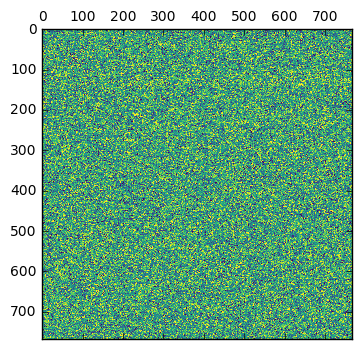

In [87]:
plt.matshow(test, cmap = 'viridis')

In [88]:
test1 = np.loadtxt('../Data/AFM/AggregatedData/ClassificationTest/10-10.txt')

In [89]:
print (test1.shape)


(589824, 6)


In [90]:
test2 = test1.reshape((768, 768, 6))

In [91]:
print (test2.shape)

(768, 768, 6)


In [79]:
test3 = np.append(scan, test2, axis = 1)
print(test3.shape)

(589824, 6)


In [80]:
print (test3)

[[  6.94630000e-03  -6.02370000e-10  -3.14870000e-03   3.17390000e-03
    6.09030000e-03   0.00000000e+00]
 [  5.09160000e-03  -1.07080000e-09  -3.15750000e-03  -2.19400000e-03
   -9.53400000e-03   0.00000000e+00]
 [  6.98680000e-03  -1.20940000e-09  -3.16610000e-03  -2.70930000e-02
   -4.07830000e-02   0.00000000e+00]
 ..., 
 [ -6.47930000e-04  -8.57880000e-12  -6.34420000e-03  -8.38540000e-03
   -1.60730000e-02   0.00000000e+00]
 [ -6.34540000e-04  -8.07070000e-12  -6.32590000e-03  -8.27460000e-03
   -1.59150000e-02   0.00000000e+00]
 [ -2.12110000e-03   1.03720000e-09  -6.30750000e-03  -3.76900000e-03
   -1.31910000e-04   0.00000000e+00]]
